In [1]:
from validphys.api import API
import sys

# Add the path to the library folder
sys.path.append('./lib')

from utils import XGRID, build_fk_matrix, regularize_matrix
from model import PDFmodel, generate_mse_loss
from gen_dicts import generate_dicts
from plot_utils import plot_eigvals
from validphys.api import API

import numpy as np
import pandas as pd

Using Keras backend


In [24]:
import matplotlib.pyplot as plt

In [2]:
seed = 14132124

In [3]:
# List of DIS dataset
dataset_inputs = [
  #{'dataset': 'NMC_NC_NOTFIXED_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'NMC_NC_NOTFIXED_P_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'SLAC_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{#'dataset': 'SLAC_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'BCDMS_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'BCDMS_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NU-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NB-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NU-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NB-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_225GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_251GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_300GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_CC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_CC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_318GEV_EAVG_CHARM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'HERA_NC_318GEV_EAVG_BOTTOM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
]

# Dictionary for validphys API
common_dict = dict(
    dataset_inputs=dataset_inputs,
    metadata_group="nnpdf31_process",
    use_cuts='internal',
    datacuts={'q2min': 3.49, 'w2min': 12.5},
    theoryid=40000000,
    t0pdfset='NNPDF40_nnlo_as_01180',
    use_t0=True
)

In [4]:
# Retrieve data from NNPDF
groups_data = API.procs_data(**common_dict)
tuple_of_dicts = generate_dicts(groups_data)
fk_table_dict = tuple_of_dicts.fk_tables
central_data_dict = tuple_of_dicts.central_data
FK = build_fk_matrix(fk_table_dict)

In [5]:
print(FK.shape)

(687, 450)


In [6]:
C = API.groups_covmat_no_table(**common_dict)

# Serialize covmat
C_index = C.index
C_col = C.columns
Cinv = np.linalg.inv(C)
Cinv = pd.DataFrame(Cinv, index=C_index, columns=C_col)

# Diagonalize covariance matric
eigvals_Cinv, R_Y = np.linalg.eigh(Cinv)
if eigvals_Cinv[-1] > eigvals_Cinv[0]:
    eigvals_Cinv = eigvals_Cinv[::-1]
    R_Y = R_Y[:,::-1]
D_Y = np.zeros_like(R_Y)
np.fill_diagonal(D_Y, eigvals_Cinv)

LHAPDF 6.5.4 loading /Users/ldeldebb/miniconda3/envs/nnpdf-dev/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


In [15]:
print(np.linalg.cond(C))
print(np.linalg.cond(C))
print(C.shape)

58240.80249281692
58240.80249281692
(687, 687)


In [6]:
# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError

In [7]:
nnpdf_model = PDFmodel(input=XGRID,
                       outputs=9,
                       architecture=[28,20],
                       activations=['tanh', 'tanh'],
                       kernel_initializer='RandomNormal',
                       user_ki_args={'mean': 0.0, 'stddev': 1.0},
                       seed=seed,
                       dtype='float64')
NTK = nnpdf_model.compute_ntk()

# Flatten NTK
prod = 1
oldshape = NTK.shape
for k in oldshape[2:]:
    prod *= k
NTK_flat = np.array(NTK).reshape(prod,-1)

# Compute predictions at initialization
f0 = nnpdf_model.predict(squeeze=True)

Load data from GD training

In [8]:
import pickle
with open('training.pkl', 'rb') as file:
    results = pickle.load(file)

pred_in_time = results[1]
pdfs_in_time = results[2]
learning_rate_gd = 0.00000001

# Computing matrices from notes
-------------------------------

In [16]:
tol = None#np.finfo(np.float64).eps

### $M = (FK)^T C_Y^{-1} (FK) = RDR^T$

check that Cinv is positive:  True
check that M is positive:  True
check that M is positive after reg:  True
14991.941843486544
[]


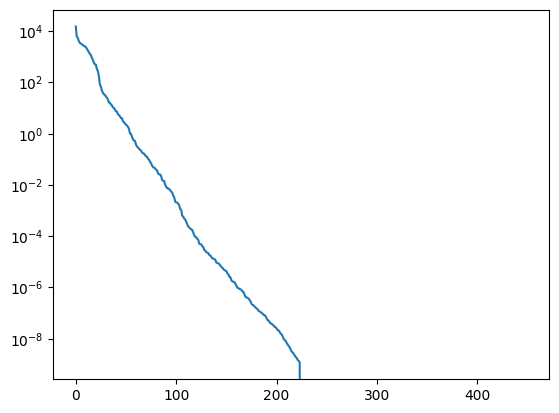

In [322]:
M = FK.T @ Cinv.to_numpy() @ FK
print('check that Cinv is positive: ', is_positive_definite(Cinv))
print('check that M is positive: ', is_positive_definite_eigenvalues(M))
M, (eigvals_M, R) = regularize_matrix(M, tol=tol)
print('check that M is positive after reg: ', is_positive_definite_eigenvalues(M))
print(eigvals_M[0])
print(eigvals_M[eigvals_M<0])
plt.plot(eigvals_M)
plt.yscale('log')

# Construct diagonal matrix
D = np.zeros_like(R)
np.fill_diagonal(D, eigvals_M)

Max eigenvalue:  14991.94184348655
Consistency test between the two sets of e.vals: True


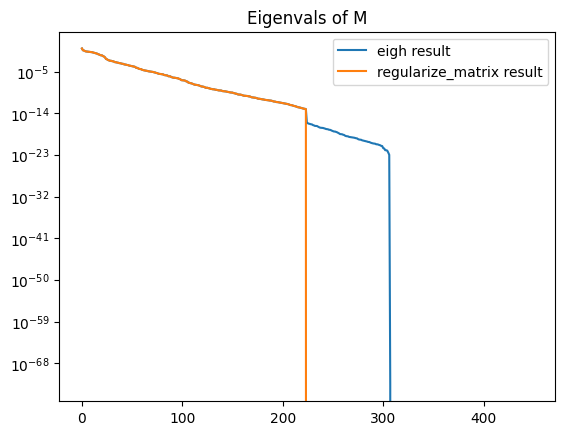

In [242]:
eigenvalues, eigenvectors = np.linalg.eigh(M)
eigenvalues = eigenvalues[::-1]
eigenvectors_reordered = eigenvectors[:, ::-1]
print('Max eigenvalue: ', eigenvalues[0])
print('Consistency test between the two sets of e.vals:', np.allclose(eigenvalues,eigvals_M))
plt.plot(eigenvalues/eigenvalues[0],label='eigh result')
plt.plot(eigvals_M/eigenvalues[0],label='regularize_matrix result')
plt.legend()
plt.yscale('log')
plt.title('Eigenvals of M')
plt.show()

In [240]:
np.linalg.norm(eigenvalues-eigvals_M)/eigenvalues[0]
np.allclose(eigenvalues,eigvals_M)

True

In [51]:
print(np.linalg.cond(C))

58240.80249281692


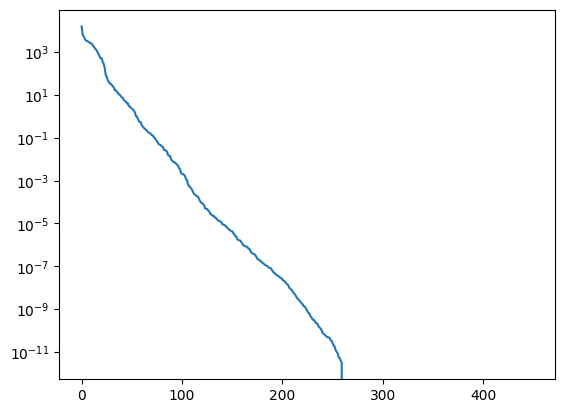

14991.941843486544 0.0 0.0 6085.404494489441


In [40]:
plt.plot(np.diagonal(D))
plt.yscale('log')
plt.show()
print(D[0,0],D[0,1],D[0,1],D[1,1])

2.626062531330937


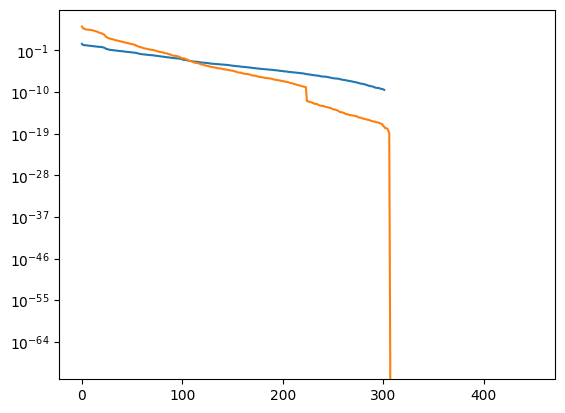

In [68]:
U,S,VT = np.linalg.svd(FK)
print(S[0])
plt.plot(S[S>(1e-10 * S[0])])
plt.plot(eigenvalues)
plt.yscale('log')
plt.show()

In [190]:
print(S.shape,VT.shape,U.shape)

(450,) (450, 450) (687, 687)


In [42]:
Sigma = D[0,0]*np.diag(S)
print(Sigma[0,0])
print(D[0,0])
Diff = Sigma - D
print(np.linalg.norm(Diff))

39369.77674707247
14991.941843486544
60546.839087717926


In [34]:
tol=1e-9
S_tol = S[S > tol]
print(S_tol.shape)

(292,)


In [180]:
# Function to check if a matrix is symmetric with a tolerance
def is_symmetric(matrix, tol=1e-9):
    return np.allclose(matrix, matrix.T, atol=tol)

is_symmetric(M)

True

In [321]:
def is_positive_definite(matrix):
    try:
        # Attempt the Cholesky decomposition
        _ = np.linalg.cholesky(matrix)
        return True  # If no error, it's positive definite
    except np.linalg.LinAlgError:
        return False  # If error occurs, it's not positive definite

def is_positive_definite_eigenvalues(matrix):
    # Compute eigenvalues
    eigenvalues = np.linalg.eigvals(matrix)
    # Check if all eigenvalues are positive
    return np.allclose(eigenvalues, np.maximum(eigenvalues,0),atol=1e-9)


check that M is symmetric:  True
check that M is positive:  False   True
check that U = V on first evect:  True
Eigenvector 1 vs Left Singular Vector 1: True
Eigenvector 2 vs Left Singular Vector 2: True
Eigenvector 3 vs Left Singular Vector 3: True
Eigenvector 4 vs Left Singular Vector 4: True
Eigenvector 5 vs Left Singular Vector 5: True
Eigenvector 6 vs Left Singular Vector 6: True
Eigenvector 7 vs Left Singular Vector 7: True
Eigenvector 8 vs Left Singular Vector 8: True
Eigenvector 9 vs Left Singular Vector 9: True
Eigenvector 10 vs Left Singular Vector 10: True
Eigenvector 11 vs Left Singular Vector 11: True
Eigenvector 12 vs Left Singular Vector 12: True
Eigenvector 13 vs Left Singular Vector 13: True
Eigenvector 14 vs Left Singular Vector 14: True
Eigenvector 15 vs Left Singular Vector 15: True
Eigenvector 16 vs Left Singular Vector 16: True
Eigenvector 17 vs Left Singular Vector 17: True
Eigenvector 18 vs Left Singular Vector 18: True
Eigenvector 19 vs Left Singular Vector 19:

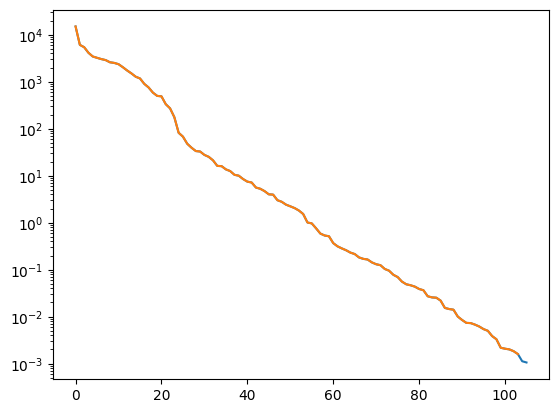

In [342]:
MU,MS,MVT = np.linalg.svd(M)
#MS = MS[::-1]

Nvect=109
print('check that M is symmetric: ', is_symmetric(M))
print('check that M is positive: ', is_positive_definite(M), ' ', is_positive_definite_eigenvalues(M))
print('check that U = V on first evect: ', np.allclose(MU[:Nvect,:Nvect],MVT.T[:Nvect,:Nvect]))

for i in range(120):
    # Check if eigenvectors and left singular vectors are the same, within a tolerance
    comparison = np.allclose(np.abs(eigenvectors_reordered[:, i]), np.abs(MU[:, i]),rtol=1.e-6)
    print(f"Eigenvector {i+1} vs Left Singular Vector {i+1}: {comparison}")
for i in range(120):
    # Check if eigenvectors and left singular vectors are the same, within a tolerance
    comparison = np.allclose(np.abs(eigenvectors_reordered[:, i]), np.abs(MVT[i, :]),rtol=1.e-6)
    print(f"Eigenvector {i+1} vs Right Singular Vector {i+1}: {comparison}")

print('test the matrices of eigenvectors: ', np.allclose(R,MVT))
print('Check that the sing values correspond to the e.vals: ', np.allclose(MS[MS > 5.0e-16 * MS[0]],eigenvalues[eigenvalues > 5.e-16 * eigenvalues[0]]))

plt.plot(MS[MS > 5.0e-8 * MS[0]])
plt.plot(eigenvalues[eigenvalues > 1.e-7 * eigenvalues[0]])
plt.yscale('log')
plt.show()

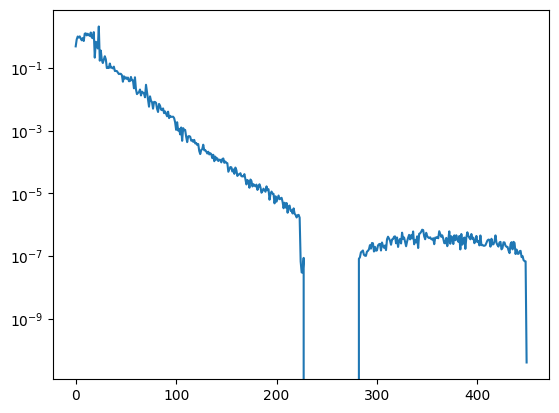

In [251]:
arr = np.zeros(len(MVT[0]))

for k in range(len(MVT[0])):
    arr[k] = np.linalg.norm(FK@MVT[k])

# for k in range(200):
#     print(k, ': ', MVT[k].shape, '  ', np.linalg.norm(FK@MVT[k]))
#     #print(i, ': ', MU[i]+eigenvectors_reordered[i]

plt.plot(arr)
plt.yscale("log")
plt.show()

In [269]:
def is_diagonal(matrix, tol):
    # Extract the diagonal elements
    diagonal_elements = np.diag(matrix)
    
    # Create a matrix where all diagonal elements are set to zero
    non_diagonal_elements = matrix - np.diag(diagonal_elements)
    
    # Check if all non-diagonal elements are zero
    return np.all(abs(non_diagonal_elements)<tol)

In [329]:
# Check if float128 is available
try:
    np.float128
    print("float128 is available")
except AttributeError:
    print("float128 is not available on this platform")


float128 is not available on this platform


In [274]:
print('Check MVT is orthogonal: ', is_identity_matrix(MVT@MVT.T))

Mrot = MVT@M@MVT.T
print('Mrot shape: ', Mrot.shape)
print('Mrot condition number: ', np.linalg.cond(Mrot)) 
print('Check Mrot is diagonal: ', is_diagonal(Mrot,1e-10))

ImageDim=120
MSub = Mrot[:ImageDim,:ImageDim]
print('MSub shape: ', MSub.shape)
print('MSub condition number: ', np.linalg.cond(MSub)) 
print('Check MSub is diagonal: ', is_diagonal(MSub,1e-10))

Check MVT is orthogonal:  True
Mrot shape:  (450, 450)
Mrot condition number:  1.014407844604271e+36
Check Mrot is diagonal:  True
MSub shape:  (120, 120)
MSub condition number:  162022809.41865036
Check MSub is diagonal:  True


(450,)


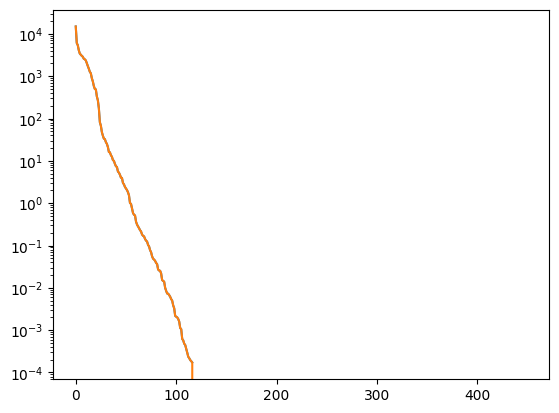

In [326]:
MSpad = np.where(abs(MS) > 1e-8 * MS[0],MS,0)
print(MSpad.shape)
plt.plot(MS[MS > 1.0e-8 * MS[0]])
plt.plot(MSpad)
plt.yscale('log')
plt.show()

In [100]:
M_reconstructed = np.dot(MU, np.dot(np.diag(MSpad),MVT))
#print(MSpad)
print(np.linalg.norm(M-M_reconstructed,ord=np.inf))
print(np.linalg.cond(M_reconstructed))

2.3269725782887832e-10
inf


In [ ]:
MS_orth = MS[MS > 12.0e-16 * MS[0]]
print(MS_orth.shape)
#print(np.linalg.norm(MU-MVT.T))
#print(np.linalg.norm(MU[0]))
#print(MU[0])
size=MS.size
size_orth = MS_orth.size
print(size, ' ', size_orth)

(224,)
18.724459739831268
450   224


In [176]:
# Function to check if a matrix is an identity matrix
def is_identity_matrix(matrix):
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        return False
    
    # Create an identity matrix of the same size as the input matrix
    identity_matrix = np.eye(matrix.shape[0])
    
    # Check if the matrix is equal to the identity matrix
    return np.allclose(matrix, identity_matrix)

Amat = MU@MVT
#print(Amat.diagonal())
is_identity_matrix(Amat)


False

In [ ]:
#build a truncated matrix by summing over size_orth singular values

mat = np.zeros((MU[0].size,MVT[0].size))

print(mat.shape, ' ', M.shape)

for i in range(MS_orth.shape[0]):
    mat += MS[i] * np.outer(MU.T[i],MVT[i])

k=size_orth
U_k = MU[:, :k]
S_k = np.diag(MS[:k])
Vt_k = MVT[:k, :]
M_approx = np.dot(U_k, np.dot(S_k, Vt_k))

print(np.linalg.cond(M_approx))

print(mat.shape, M_approx.shape)
print('dist between truncations: ', np.linalg.norm(mat-M_approx))

# Plot the heatmap using imshow()
#plt.imshow(mat-M, cmap='viridis', interpolation='nearest')
#plt.colorbar()  # Show color bar
#plt.title('Heatmap using matplotlib')
#plt.show()

print('dist to the original: ', np.linalg.norm(M-mat,ord=np.inf))

(450, 450)   (450, 450)
inf
(450, 450) (450, 450)
dist between truncations:  1.2404542814700638e-11
dist to the original:  2.346319581729824e-10


In [285]:
def is_orthogonal(matrix, tol=1e-9):
    # Compute the transpose of the matrix
    transpose = matrix.T
    
    # Multiply matrix by its transpose
    product = np.dot(matrix, transpose)
    
    # Check if the product is close to the identity matrix
    identity = np.eye(matrix.shape[0])
    
    # Check if all elements are within the tolerance level
    return np.allclose(product, identity, atol=tol)


In [288]:
print(is_orthogonal(MVT),is_orthogonal(U))


True True


### $\tilde{H} = D^{1/2} R^T \Theta R D^{1/2}$

In [11]:
ntk, (eigvals_ntk, R_ntk) = regularize_matrix(NTK_flat)
H_tilde = np.sqrt(D) @ R.T @ ntk @ R @ np.sqrt(D)
H_tilde, (eigvals_H_tilde, eigvecs_H_tilde) = regularize_matrix(H_tilde, tol=tol)

# Check if symmetric
print(f'Is symmetric: {np.allclose(H_tilde, H_tilde.T)}')

Is symmetric: True


### $\tilde{H_{\epsilon}} = D^{1/2} R^T \Theta R D^{1/2}$

In [12]:
H_eps_tilde = np.sqrt(D_Y) @ R_Y.T @ FK @ ntk @ FK.T @ R_Y @ np.sqrt(D_Y)
H_eps_tilde, (eigvals_H_eps_tilde, eigvecs_H_eps_tilde) = regularize_matrix(H_eps_tilde, tol=tol)

# Check if symmetric
print(f'Is symmetric: {np.allclose(H_eps_tilde, H_eps_tilde.T)}')

Is symmetric: True


### $b = \Theta (FK)^T C_Y^{-1} y \hspace{5mm} \textrm{and} \hspace{5mm} \tilde{b} = D^{1/2} R^T b$

In [13]:
b = ntk @ FK.T @ Cinv.to_numpy(dtype='float64') @ Y.to_numpy('float64')
b_tilde = np.sqrt(D) @ R.T @ b

# Plots of the eigenvalues

In [ ]:
fig, axs = plot_eigvals(eigvals_H_eps_tilde, figsize=(10,8), title=r'$H_{\epsilon} = D^{1/2}_Y R^T_Y (FK) \Theta (FK)^T R_Y D^{1/2}_Y$')

In [ ]:
fig, axs = plot_eigvals(eigvals_H_tilde, 
                        figsize=(10,8), 
                        title=r'$\tilde{H}= D^{1/2} R^T \Theta R D^{1/2}$,  $M = RDR^T$')
fig.savefig('../../../doc/figs/Htilde_eigvals.pdf')

In [ ]:
fig, axs = plot_eigvals(eigvals_ntk, figsize=(10,8), title='')
axs.set_title(r'Eigenvalues of $\Theta$', fontsize=20)
fig.savefig('../../../doc/figs/ntk_eigvals.pdf')

In [ ]:
fig, axs = plot_eigvals(eigvals_M, figsize=(10,8), title=r'Eigenvalues of $M = (FK)^T C_Y^{-1} (FK)$')
#axs.set_title(r'Eigenvalues of $\Theta$', fontsize=20)
#fig.savefig('../../../doc/figs/m_eigvals.pdf')

# Utility functions for the null space

In [25]:
import scipy as sp
from typing import Any, Tuple
import numpy.typing as npt
def null_space_eig(eigvals: npt.ArrayLike, eigvecs: npt.NDArray[np.float64], tol: float = None) -> Tuple[npt.NDArray[np.float64],npt.NDArray[np.float64]]:
  """
  Compute the kernel and its orthogonal space given as set
  of eigenvalues and eigenvectors.

  The kernel space is constructed out of the eigenvectors whose eigenvalue
  is zero. The eigenvalues are compared to tolerance. If the value is greater
  than the tolerance, then it is considered non-zero.

  The tolerance is a parameter of this function. If `tol` is not provided,
  then it is defined as the product of the largest eigenvalue with the
  smallest precision number given the type the of the eigenvalues.

  Parameters
  ----------
  eigvals: array
    List of eigenvalues that are compared to the tolerance.
  eigvecs: NDArray
    Matrix where the second index select the i-th eigenvector relative
    to the i-th eigenvalue, and the first index runs over the components
    of each eigenvector.
  tol: float
    The tolerance for the zero-value veto.

  Return
  ------
  The two sets of basis vectors for the kernel and its orthogonal space. These
  are subspaces of the original eigenspace provided as an argument. The indexing
  follows the same as `eigvecs`.
  """
  if tol is None:
    tol = np.amax(eigvals, initial=0.) * np.finfo(eigvecs.dtype).eps
  num = np.sum(eigvals > tol, dtype=int) # Number of non-zero eigenvalues
  ker = eigvecs[:,num:]
  orth = eigvecs[:,:num]
  return ker, orth
  
def project_matrix(matrix, basis1, basis2=None):
  """
  Project the matrix into a given basis. If two bases are given,
  then the first basis specifies the projection of the matrix on
  the right space, while the second basis for the left space.

  In particular, the projection is computed as follows $\delta$

  ..math::

    M_{i_{B_1} j_{B_2}} = \sum_{i=1}^{dim(B_1)} \sum_{j=1}^{dim(B_2)}
    \mathbf{v}_{B_2}^{(j)T} \cdot M \cdot \mathbf{v}_{B_1}^{(i)}

  where :math:`\mathbf{v}_{B}^{(i)}` is the i-th vector of the basis B.

  If `basis2` is not provided, then basis2 is taken to be standard basis
  (i.e. the one specified by the identity matrix).

  Note that the matrix is not required to be squared.

  Parameters
  ----------
  matrix: NDArray
    The matrix that is projected.
  basis1: NDArray
    The (right) basis on which the matrix is projected.
  basis2: NDArray
    The (left) basis on which the matrix is projected.

  Returns
  -------
  The projection of the matrix into the bases `basis1` and, if 
  given `basis2`.
  """
  if basis2 is None:
    basis2 = np.eye(matrix.shape[0])

  emb_space1 = basis1.shape[0] # Embedding space base 1
  emb_space2 = basis2.shape[0] # Embedding space base 2

  # Check if the bases are compatible with the matrix
  if matrix.shape[0] != emb_space2 or matrix.shape[1] != emb_space1:
    raise ValueError ('The matrix cannot be projected into the two bases.')

  M_orth = basis2.T @ matrix @ basis1

  return M_orth

def project_vector(vector, basis):
  """
  Project a vector into a given basis.
  """
  basis_dim = basis.shape[1]
  space_dim = basis.shape[0]
  if space_dim != vector.shape[0]:
    raise ValueError ('The matrix cannot be projected into the basis')
  
  res = [np.dot(vector, basis[:,i]) for i in range(basis_dim)]
  return res

# Null space of $M$ and $\tilde{H}$

In this part, we compute the $\textrm{ker}(M)$ and its orthogonal space $R(M)$. We then project the matrix $M$ into the bases specified by these two spaces. In particular, we apply
$$
M_{i_{B_1} j_{B_2}} = \sum_{i=1}^{\textrm{dim}(B_1)} \sum_{j=1}^{\textrm{dim}(B_2)}
  (\mathbf{v^{(j)}_{B_2}})^T \cdot \mathbf{M} \cdot \mathbf{v^{i}_{B_1}} \,,
$$
where $\mathbf{v^{i}_{B_1}}$ and $\mathbf{v^{j}_{B_2}}$ are the i-th and j-th vectors of the respective bases.

When we compute the null space, we need to decide the threshold for the smallest distinguishable eigenvalue. If no tolerance is provided to the `null_space_eig` function, the default option is used (see above). Otherwise, we can specify a custom tolerance based. We could choose such value by looking at Looking at the eigenvalues of the matrix $M$:

In [26]:
for i, val in enumerate(eigvals_M):
  print(f'{i+1} : {val}')

1 : 4501962.482500519
2 : 1611794.2231508063
3 : 656336.8239098041
4 : 529986.6542886588
5 : 160906.35937601666
6 : 152653.25231474565
7 : 137431.8778275906
8 : 111497.0201272436
9 : 103530.19569058708
10 : 77534.6677476217
11 : 74051.62283799764
12 : 51334.52972635849
13 : 46276.75356787624
14 : 40624.587537446314
15 : 36797.59404387643
16 : 34856.831448954945
17 : 31118.33117213023
18 : 24162.090154794583
19 : 23009.658665213006
20 : 21393.045643644942
21 : 20771.815897040124
22 : 18579.258785449296
23 : 16966.64697764954
24 : 16151.38296418803
25 : 15709.19291735395
26 : 15452.571087635839
27 : 14805.017362400145
28 : 14424.193238841144
29 : 13299.732276637764
30 : 13045.068878934711
31 : 12391.612302926651
32 : 11969.216349270544
33 : 10837.493680749745
34 : 10399.045437910148
35 : 9984.69135816926
36 : 9619.885504185886
37 : 9023.136069034628
38 : 8732.156929857694
39 : 8471.1654950175
40 : 8042.005406821709
41 : 7794.2930522539145
42 : 7151.795793641496
43 : 6854.480170365759
44 

In [27]:
ker_M, orth_M = null_space_eig(eigvals_M, R)

In [28]:
M_pp = project_matrix(M, orth_M, orth_M)
M_kk = project_matrix(M, ker_M, ker_M)
M_pk = project_matrix(M, ker_M, orth_M)
M_kp = project_matrix(M, orth_M, ker_M)

Now the matrix $M$ is decomposed as follows
$$
\mathbf{M} = \left(\begin{matrix}
\mathbf{M}_{KK} & \mathbf{M}_{K \bot}\\
\mathbf{M}_{\bot K} & \mathbf{M}_{\bot \bot}\\
\end{matrix} \right) \,.
$$
Note that, by definition of null space, only $M_{\bot\bot} \neq 0$. The next cell checks if that is effectively true.

In [29]:
print(f'M_pp ?= 0 : {np.allclose(np.zeros_like(M_pp), M_pp)}')
print(f'M_kk ?= 0 : {np.allclose(np.zeros_like(M_kk), M_kk)}')
print(f'M_kp ?= 0 : {np.allclose(np.zeros_like(M_kp), M_kp)}')
print(f'M_pk ?= 0 : {np.allclose(np.zeros_like(M_pk), M_pk)}')

M_pp ?= 0 : False
M_kk ?= 0 : True
M_kp ?= 0 : True
M_pk ?= 0 : True


By constructing the matrix $M_{\bot\bot}$, we have projected out the null modes. Hence, this matrix must be invertible. We check that in the following cell:

In [30]:
M_pp_inv = np.linalg.inv(M_pp)
print(f'M_pp_inv @ M_pp ?= Id: {np.allclose(M_pp_inv @ M_pp, np.eye(M_pp.shape[0]))}')
print(f'M_pp @ M_pp_inv ?= Id: {np.allclose(M_pp @ M_pp_inv, np.eye(M_pp.shape[0]))}')

M_pp_inv @ M_pp ?= Id: True
M_pp @ M_pp_inv ?= Id: True


We also need to compute the null space and its orthogonal space of the evolution matrix $\tilde{H}$

In [31]:
ker_H_tilde, orth_H_tilde = null_space_eig(eigvals_H_tilde, eigvecs_H_tilde)

In [32]:
H_tilde_pp = project_matrix(H_tilde, orth_H_tilde, orth_H_tilde)
H_tilde_kk = project_matrix(H_tilde, ker_H_tilde, ker_H_tilde)
H_tilde_pk = project_matrix(H_tilde, ker_H_tilde, orth_H_tilde)
H_tilde_kp = project_matrix(H_tilde, orth_H_tilde, ker_H_tilde)

In [33]:
print(f'H_tilde_pp ?= 0 : {np.allclose(np.zeros_like(H_tilde_pp), H_tilde_pp)}')
print(f'H_tilde_kk ?= 0 : {np.allclose(np.zeros_like(H_tilde_kk), H_tilde_kk)}')
print(f'H_tilde_kp ?= 0 : {np.allclose(np.zeros_like(H_tilde_kp), H_tilde_kp)}')
print(f'H_tilde_pk ?= 0 : {np.allclose(np.zeros_like(H_tilde_pk), H_tilde_pk)}')

H_tilde_pp ?= 0 : False
H_tilde_kk ?= 0 : True
H_tilde_kp ?= 0 : True
H_tilde_pk ?= 0 : True


Note that the null space of $\tilde{H}$ and that of $M$ are not the same in general:

In [34]:
print(f'{ker_H_tilde.shape} != {ker_M.shape}')

(450, 367) != (450, 130)


In particular, the null space of the evolution matrix $\tilde{H}$ is larger that that of $M$. This is kind of expected, as the evolution matrix accounts for the contribution of the NTK which is known to provide many small eigenvalues.

# When is $\tilde{H}$ invertible?
The matrix $\tilde{H}$ is not invertible on its own. We can check that directly in the following cell:

In [35]:
try:
  np.linalg.inv(H_tilde)
except np.linalg.LinAlgError:
  print('Error detected. The matrix is not ivertible.')

Error detected. The matrix is not ivertible.


This was expected, as $\tilde{H}$ is constructed from the full matrix $M$. We can try to construct $\tilde{H}$ using $M_{\bot\bot}$, which should be equivalent to projecting $\tilde{H}$ in $M_{\bot\bot}$. Let's see:

In [36]:
H_tilde_p = project_matrix(H_tilde, orth_M, orth_M)
try:
  H_tilde_p_inv = np.linalg.inv(H_tilde_p)
except np.linalg.LinAlgError:
  print('Error detected. The matrix is not ivertible.')

It seems to work. However, if we try to compute $\tilde{H}_{\bot} \cdot \tilde{H}_{\bot}^{-1}$ we obtain

In [37]:
inv = np.linalg.inv(H_tilde_p)
print(f'Printing the first 10 diagonal entries: \n{(inv @ H_tilde_p).diagonal()[:10]}')

Printing the first 10 diagonal entries: 
[-101239.5625    -91862.         12401.75       18982.3125
   49819.75     -146967.53125  -790683.25       -8488.546875
   80398.0625   -145181.265625]


We see that this is not what we thought we computed, namely the inverse matrix of $\tilde{H}_{\bot}$. The reason is the high condition number of the matrix, which makes it highly unstable.

We then resort to $\tilde{H}_{\bot\bot}$ computed before. This takes in account the null modes of the NTK:

In [38]:
try:
  H_tilde_pp_inv = np.linalg.inv(H_tilde_pp)
except np.linalg.LinAlgError:
  print('Error detected. The matrix is not ivertible.')

print(f'Printing the first 10 diagonal entries: \n{(H_tilde_pp_inv @ H_tilde_pp).diagonal()[:10]}')

Printing the first 10 diagonal entries: 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Projection of $(FK)$: $(FK)_{\bot}$ and $(FK)_{K}$

We also need to project $(FK)$ into these two spaces. Remember that $(FK)$ is a linear map from the space of PDF to the space of the data
$$
(FK) : \mathbb{R}^{\textrm{PDF}} \longrightarrow \mathbb{R}^{\textrm{Data}} \,.
$$
The projection is then applied to the right-space only, which is the PDF space. Hence, after projection, the $(FK)$ table can be written as
$$
(FK) = \left( \, (FK)_{K} \hspace{5mm}  (FK)_{\bot} \,\right) \,,
$$
where each $(FK)_{B}$ is a linear map from PDF to data space. Note that $\textrm{ker}(M) = \textrm{ker}(FK)$. Thus, also in this case $(FK)_{K}$. We can check that in the following cell:

In [39]:
#FK, (s_FK, vh_FK) = regularize_matrix(FK, tol=np.finfo(FK.dtype).eps * np.amax(eigvals_M, initial=0.)/ np.amax(s_FK, initial=0.))
FK_p = project_matrix(FK, orth_M, np.eye(FK.shape[0]))
FK_k = project_matrix(FK, ker_M, np.eye(FK.shape[0]))
ntk_pp = project_matrix(ntk, orth_M, orth_M)

A naive comparison of the two components $(FK)_K$ and $(FK)_{\bot}$ would not lead to the desired result, as shown in the following cell:

In [46]:
print(f'FK_k ?= 0 : {np.allclose(np.zeros_like(FK_k), FK_k)}')
print(f'FK_p ?= 0 : {np.allclose(np.zeros_like(FK_p), FK_p)}')

FK_k ?= 0 : False
FK_p ?= 0 : False


The reason being that the tolerance used to construct $\textrm{Ker}(M)$ and $R(M)$ was defined using the largest eigenvalue of the the matrix $M$. When we move to $(FK)$, we then need to scale the tolerance appropriately so that we have consistent results. In that case, we have $M \sim (FK)^2$, and we could expect that $\textrm{tol}_{FK} = \sqrt{\textrm{tol}_M}$. Let's try and see if we get the expected result:


In [47]:
tol =  np.sqrt(np.amax(eigvals_M, initial=0.) * np.finfo(eigvals_M.dtype).eps)
print(f'Comparing with tolerance = {tol}.')
print(f'FK_k ?= 0 : {np.allclose(np.zeros_like(FK_k), FK_k, atol=tol)}')
print(f'FK_p ?= 0 : {np.allclose(np.zeros_like(FK_p), FK_p, atol=tol)}')

Comparing with tolerance = 3.161702833623269e-05.
FK_k ?= 0 : True
FK_p ?= 0 : False


As a consistency check, we can verify that $(FK) \Theta (FK)^T = (FK_{\bot}) \Theta_{\bot\bot} (FK_{\bot})^T$:

In [53]:
# TODO
# I'm not sure about tol here...
test1 = FK_p @ ntk_pp @ FK_p.T
test2 = FK @ ntk @ FK.T
np.allclose(test1, test2, atol=tol)

True

# Calculation of $f_{\infty}$, $\varepsilon_{\infty}$ and evolution
We now compute the limiting solution $f_{\infty}$, which is the value that minimizes the loss function.
$$
f_{\infty} = \mathbf{M}_{\bot\bot}^{-1} (FK)_{\bot}^T C_Y^{-1} y \,.
$$
We also compute
$$
\varepsilon_{\infty} = y - (FK)_{\bot}f_{\infty} = \biggl(1 - (FK)_{\bot} \mathbf{M}_{\bot\bot}^{-1} (FK)_{\bot}^T C_Y^{-1}\biggr) y\,,
$$
together with the minimum of the loss-function
$$
\mathcal{L}^{*} = \frac{1}{2} y^T C_Y^{-1} \varepsilon_{\infty}

In [54]:
f_inf = M_pp_inv @ FK_p.T @ Cinv.to_numpy(dtype='float64') @ Y.to_numpy(dtype='float64')[:,0]
eps_inf = Y.to_numpy(dtype='float64')[:,0] - FK_p @ f_inf
L_inf = 0.5 * Y.to_numpy(dtype='float64')[:,0].T @ Cinv.to_numpy(dtype='float64') @ eps_inf

We also compute the following quantity, which will be useful the description of the evolution
$$
\begin{align}
& \tilde{\varepsilon}_{\infty} = D_{Y}^{1/2} \, R_Y^T \varepsilon_{\infty} \hspace{5mm} \textrm{where} \hspace{5mm} C_Y^{-1} = R_Y D_Y R_Y^T \\
\end{align}
$$

In [55]:
eps_inf_tilde = np.sqrt(D_Y) @ R_Y.T @ eps_inf

We now check eq.(67) of the paper, that is
$$
\tilde{H}_{\varepsilon} \, \tilde{\varepsilon}_{t} = 0
$$

In [56]:
res = H_eps_tilde @ eps_inf_tilde
np.linalg.norm(res)

0.025331812661359695

# DEPRECATED
-------------
This part needs to be updated...

# Evolution of the data

In [ ]:
from functools import lru_cache

# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError
  
eps_0 = Y.to_numpy()[:,0] - FK @ f0.flatten()
Ly = (L @ Y).to_numpy()[:,0]
L_eps0 = L @ eps_0

L_eps0_tilde = [np.dot(L_eps0, eigvecs[:,k]) for k in range(eigvecs.shape[1])]
pre_computed_coefficients = [Linv @ eigvecs[:,k] * L_eps0_tilde[k] for k in range(eigvals_reg.size)] 

@lru_cache(maxsize=None)
def preds_t(t, learning_rate = 0.00001, eig_range=None):
  if eig_range is None:
    eig_range = eigvals_reg.size
  predictions = [pre_computed_coefficients[k] * np.exp(-eigvals_reg[k] * learning_rate* t) for k in range(eig_range)] 
  predictions = np.sum(predictions, axis=0)

  predictions = pd.DataFrame(predictions, index=Y.index)
  predictions = Y - predictions
  return predictions

In [ ]:
experiments = ['NMC_NC_NOTFIXED_P_EM-SIGMARED', 'SLAC_NC_NOTFIXED_P_EM-F2', 'BCDMS_NC_NOTFIXED_D_EM-F2', 'HERA_NC_318GEV_EM-SIGMARED']
exp_titles = ['NMC', 'SLAC NC P', 'BCDMS NC D', 'HERA NC 318GEV']
y_labels = [r'$\sigma$', r'$F_2$', r'$F_2$', r'$\sigma$']
t = 0.
fig_pred, axes_pred = plt.subplots(2, 2, figsize=(25, 25))  # Adjust figsize for desired plot size
preds = preds_t(t, learning_rate=learning_rate_gd)

scat_gf = []
scat_gd = []
text = []
for i, ax in enumerate(axes_pred.flat):
    y = Y.xs(level='dataset', key=experiments[i]).to_numpy()
    p = preds.xs(level='dataset', key=experiments[i]).to_numpy()
    trained_pred = pred_in_time[0][experiments[i]]
    ax.scatter(np.arange(y.size), y, color='green', label='Central data', marker='o', s=100, alpha=0.4)
    gf = ax.scatter(np.arange(y.size), p, color='orange', label='Analytical solution', marker='^', s=100)
    gd = ax.scatter(np.arange(y.size), trained_pred, color='red', label='Gradient descent', marker='v', s=100)
    scat_gf.append(gf)
    scat_gd.append(gd)
    #ax.set_xlabel(r'$x$')
    ax.set_ylabel(y_labels[i], fontsize=20)
    #ax.set_xscale('log')
    ax.set_title(exp_titles[i], x=0.8,fontsize=20, fontweight='bold')
    ax.legend(fontsize=20)
    text_t = ax.text(0.05, 1.01, f't = {t}, learning rate = {learning_rate_gd}', fontsize=20, transform=ax.transAxes)
    text.append(text_t)


plt.tight_layout()
#fig.savefig('data_evolution.pdf')

In [ ]:
experiments = ['NMC_NC_NOTFIXED_P_EM-SIGMARED', 'SLAC_NC_NOTFIXED_P_EM-F2', 'BCDMS_NC_NOTFIXED_D_EM-F2', 'HERA_NC_318GEV_EM-SIGMARED']
exp_titles = ['NMC', 'SLAC NC P', 'BCDMS NC D', 'HERA NC 318GEV']
y_labels = [r'$\sigma$', r'$F_2$', r'$F_2$', r'$\sigma$']
t = 0.
fig_eps, axes_eps = plt.subplots(2, 2, figsize=(25, 25))  # Adjust figsize for desired plot size
preds = preds_t(t, learning_rate=learning_rate_gd)

scat_gf_eps = []
scat_gd_eps = []
text_eps = []
for i, ax in enumerate(axes_eps.flat):
    y = Y.xs(level='dataset', key=experiments[i]).to_numpy()
    p = y - preds.xs(level='dataset', key=experiments[i]).to_numpy()
    trained_pred = y[:,0] - pred_in_time[int(t)][experiments[i]].numpy()
    ax.scatter(np.arange(y.size), y, color='green', label='Central data', marker='o', s=100, alpha=0.4)
    gf = ax.scatter(np.arange(y.size), p, color='orange', label='Analytical solution', marker='^', s=100)
    gd = ax.scatter(np.arange(y.size), trained_pred, color='red', label='Gradient descent', marker='v', s=100)
    scat_gf_eps.append(gf)
    scat_gd_eps.append(gd)
    #ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\epsilon$', fontsize=20)
    #ax.set_xscale('log')
    ax.set_title(exp_titles[i], x=0.8,fontsize=20, fontweight='bold')
    ax.legend(fontsize=20)
    text_t = ax.text(0.05, 1.01, f't = {t}, learning rate = {learning_rate_gd}', fontsize=20, transform=ax.transAxes)
    text_eps.append(text_t)


plt.tight_layout()
#fig.savefig('data_evolution.pdf')

In [ ]:
def compute_loss_analytical(t, eig_range=None):
  preds = preds_t(t, learning_rate=learning_rate_gd, eig_range=eig_range)
  loss = 0
  ndata = 0
  for exp in Y.index.get_level_values('dataset').unique():
    y = Y.xs(level='dataset', key=exp).to_numpy()
    Cinv_exp = Cinv.xs(level="dataset", key=exp).T.xs(level="dataset", key=exp).to_numpy()
    p = preds.xs(level='dataset', key=exp).to_numpy()
    R = y[:,0] - p[:,0]
    loss += 0.5 * R.T @ Cinv_exp @ R
    ndata += Cinv_exp.shape[0]
  return float(loss) / ndata

def compute_loss_gd(t):
  preds = pred_in_time[int(t)]
  loss = 0
  ndata = 0
  for exp, pred in preds.items():
    y = Y.xs(level='dataset', key=exp).to_numpy()
    Cinv_exp = tf.convert_to_tensor(Cinv.xs(level="dataset", key=exp).T.xs(level="dataset", key=exp).to_numpy(), name=f'Cinv_{exp}', dtype='float32')
    R = tf.convert_to_tensor(y[:,0] - pred, name=f'residue_{exp}', dtype='float32')
    Cinv_R = tf.linalg.matvec(Cinv_exp, R)
    loss += 0.5 * tf.reduce_sum(tf.multiply(R, Cinv_R))
    ndata += Cinv_exp.shape[0]
  return float(loss) / ndata


In [ ]:
time_steps_high = np.arange(1000,len(pred_in_time),1000)
time_steps_low = np.arange(0,1000,2)
time_steps = np.concatenate([time_steps_low, time_steps_high])
aloss = [compute_loss_analytical(t, eig_range=100) for t in time_steps]
gd_loss = [compute_loss_gd(t) for t in time_steps]

In [ ]:
fig_loss, ax_loss = plt.subplots(figsize=(10, 7))  # Adjust figsize for desired plot size

ax_loss.scatter(time_steps, aloss, label='Analytical solution')
ax_loss.scatter(time_steps, gd_loss, label='Gradient descent')
ax_loss.set_xlabel(r'$t$')
ax_loss.set_ylabel(r'Loss function', fontsize=20)
ax_loss.set_xscale('symlog')
ax_loss.set_title('MSE in function of training time', x=0.5, fontsize=20, fontweight='bold')
ax_loss.legend(fontsize=20)
#text_t = ax.text(0.05, 1.01, f't = {t}, learning rate = {learning_rate_gd}', fontsize=20, transform=ax.transAxes)
#text.append(text_t)


plt.tight_layout()
fig_loss.savefig('Loss_function_time.pdf')

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Animation function
# Update function for predicitons
def update_preds(t):
    preds = preds_t(t, learning_rate=learning_rate_gd)
    for i, (gf, gd, text_t) in enumerate(zip(scat_gf, scat_gd, text)):
        # Update the y-data for each subplot's line
        y = Y.xs(level='dataset', key=experiments[i]).to_numpy()
        p = preds.xs(level='dataset', key=experiments[i]).to_numpy()
        trained_pred = pred_in_time[int(t)][experiments[i]]
        data_gf = np.hstack(( np.arange(y.size)[:, np.newaxis] , p))
        data_gd = np.hstack(( np.arange(y.size)[:, np.newaxis] , trained_pred[:,np.newaxis]))
        gf.set_offsets(data_gf)  # Example: Add phase shift based on t and subplot index
        gd.set_offsets(data_gd)  # Example: Add phase shift based on t and subplot index
        text_t.set_text(f't = {t}, learning rate = {learning_rate_gd}')
    return scat_gf + scat_gd + text

# Update function for epsilon
def update_eps(t):
    preds = preds_t(t, learning_rate=learning_rate_gd)
    for i, (gf, gd, text_t) in enumerate(zip(scat_gf_eps, scat_gd_eps, text_eps)):
        # Update the y-data for each subplot's line
        y = Y.xs(level='dataset', key=experiments[i]).to_numpy()
        p = preds.xs(level='dataset', key=experiments[i]).to_numpy()
        trained_pred = pred_in_time[int(t)][experiments[i]]
        data_gf = np.hstack(( np.arange(y.size)[:, np.newaxis] , p))
        data_gd = np.hstack(( np.arange(y.size)[:, np.newaxis] , trained_pred[:,np.newaxis]))
        gf.set_offsets(data_gf)  # Example: Add phase shift based on t and subplot index
        gd.set_offsets(data_gd)  # Example: Add phase shift based on t and subplot index
        text_t.set_text(f't = {t}, learning rate = {learning_rate_gd}')
    return scat_gf + scat_gd + text

In [ ]:
ani_pred = FuncAnimation(fig_pred, update_preds, frames=np.arange(0, len(pred_in_time), 1000), interval=10, blit=True, cache_frame_data=False)
ani_eps = FuncAnimation(fig_eps, update_eps, frames=np.arange(0, len(pred_in_time), 1000), interval=10, blit=True, cache_frame_data=False)

# Save the animation in the background
ani_pred.save('prediction_evolution.mp4', writer='ffmpeg', fps=20)
ani_eps.save('epsilon_evolution.mp4', writer='ffmpeg', fps=20)